# LendingClub Loan Prediction - EDA

This notebook performs exploratory data analysis on the dataset to understand loan characteristics and identify features for predicting loan defaults. This analysis will guide feature engineering and model development for the binary classification task of predicting whether a borrower will fully pay or default on their loan.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import os
import json
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## 1. Initial Inspection


In [36]:
df = pd.read_csv("../data/lending_club_loan_two.csv")

print("Dataset Shape:", df.shape)

df.head()

Dataset Shape: (396030, 27)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

## 2. Target Variable Analysis

The target variable `loan_status` indicates the final outcome of each loan. I'll analyze its distribution and create a binary classification target.


Target Variable Distribution:
loan_status
Fully Paid     318357
Charged Off     77673
Name: count, dtype: int64

Target Variable Proportions:
loan_status
Fully Paid     0.803871
Charged Off    0.196129
Name: proportion, dtype: float64


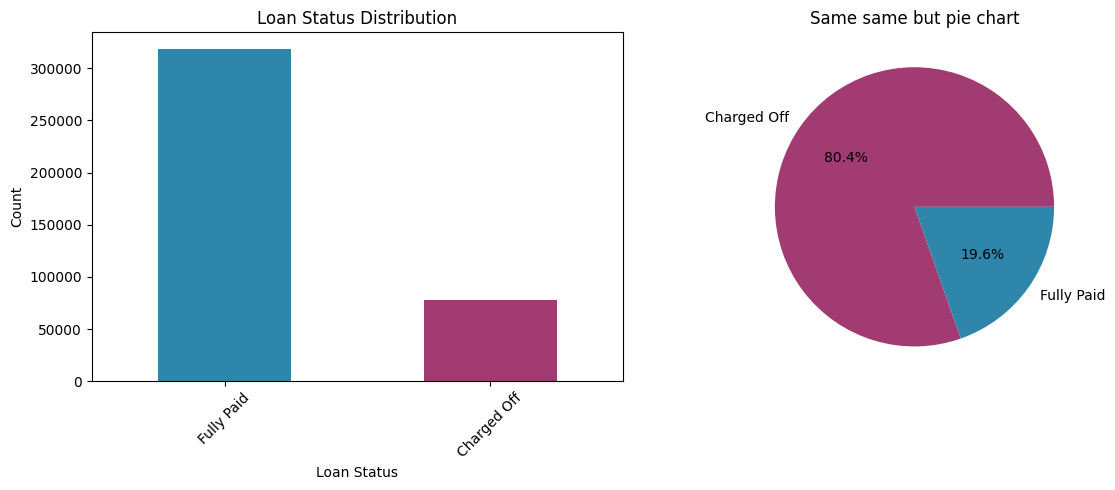

In [38]:
# analyze target variable
print("Target Variable Distribution:")
print(df["loan_status"].value_counts())
print("\nTarget Variable Proportions:")
print(df["loan_status"].value_counts(normalize=True))

# create binary (1 = Fully Paid, 0 = Charged Off)
df["loan_repaid"] = (df["loan_status"] == "Fully Paid").astype(int)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

df["loan_status"].value_counts().plot(kind="bar", ax=ax1, color=["#2E86AB", "#A23B72"])
ax1.set_title("Loan Status Distribution")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Count")
ax1.tick_params(axis="x", rotation=45)

df["loan_repaid"].value_counts().plot(
    kind="pie",
    ax=ax2,
    labels=["Charged Off", "Fully Paid"],
    colors=["#A23B72", "#2E86AB"],
    autopct="%1.1f%%",
)
ax2.set_title("Same same but pie chart")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

## 3. Missing Value Analysis


Missing Values Summary:
                      Missing_Count  Missing_Percentage
mort_acc                      37795            9.543469
emp_title                     22927            5.789208
emp_length                    18301            4.621115
title                          1756            0.443401
pub_rec_bankruptcies            535            0.135091
revol_util                      276            0.069692



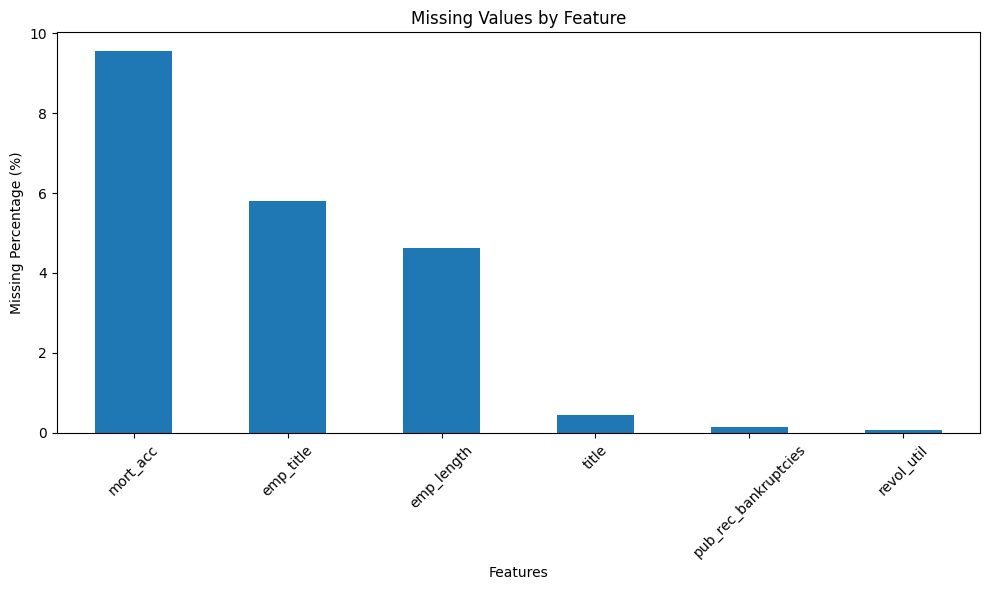

In [39]:
missing_df = pd.DataFrame({
        "Missing_Count": df.isnull().sum(),
        "Missing_Percentage": df.isnull().sum() / len(df) * 100,
    })
missing_df = missing_df[missing_df["Missing_Count"] > 0].sort_values(by="Missing_Count", ascending=False)

print("Missing Values Summary:")
print("=" * 50, end=f"\n{missing_df}\n\n")

fig, ax = plt.subplots(figsize=(10, 6))
missing_df["Missing_Percentage"].plot(kind="bar", ax=ax)
ax.set_title("Missing Values by Feature")
ax.set_xlabel("Features")
ax.set_ylabel("Missing Percentage (%)")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

## 4. Numerical Feat Analysis


In [40]:
num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
num_feats.remove("loan_repaid")  # remove target

print(f"Numerical Features ({len(num_feats)}):")
print(num_feats)

print("\nNumerical Features Summary:")
df.describe()

Numerical Features (12):
['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

Numerical Features Summary:


,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,loan_repaid
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000,396030.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648,0.803871
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174,0.397068
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000,1.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000,1.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000,1.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000,1.000000



Correlation with Target Variable:
mort_acc                0.073111
annual_inc              0.053432
total_acc               0.017893
revol_bal               0.010892
pub_rec_bankruptcies   -0.009383
pub_rec                -0.019933
open_acc               -0.028012
installment            -0.041082
loan_amnt              -0.059836
dti                    -0.062413
revol_util             -0.082373
int_rate               -0.247758
Name: loan_repaid, dtype: float64


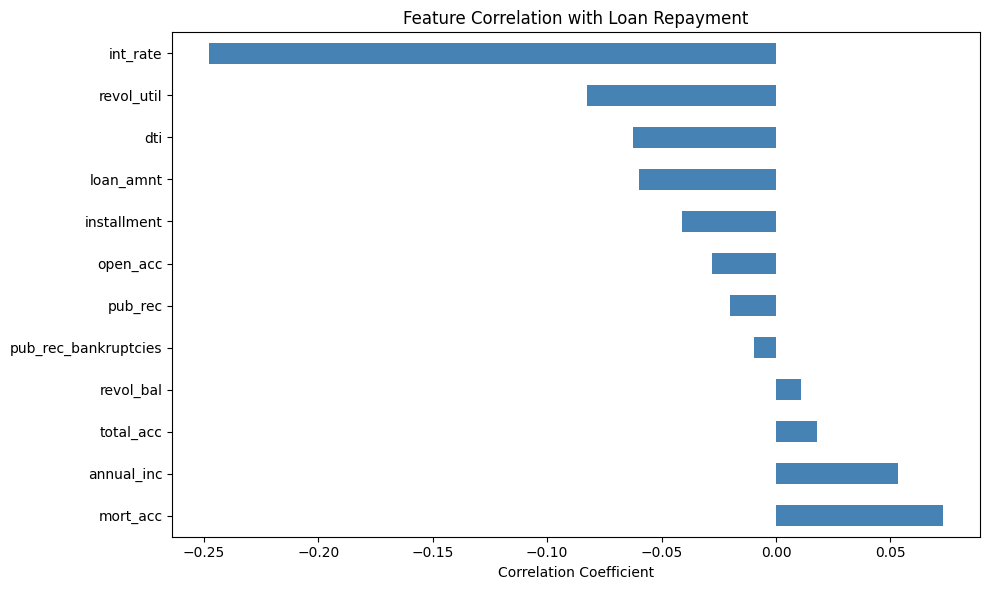

In [41]:
corr = df[num_feats + ["loan_repaid"]].corr()["loan_repaid"].drop("loan_repaid").sort_values(ascending=False)

print("\nCorrelation with Target Variable:")
print(corr)

plt.figure(figsize=(10, 6))
corr.plot(kind="barh", color="steelblue")
plt.title("Feature Correlation with Loan Repayment")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

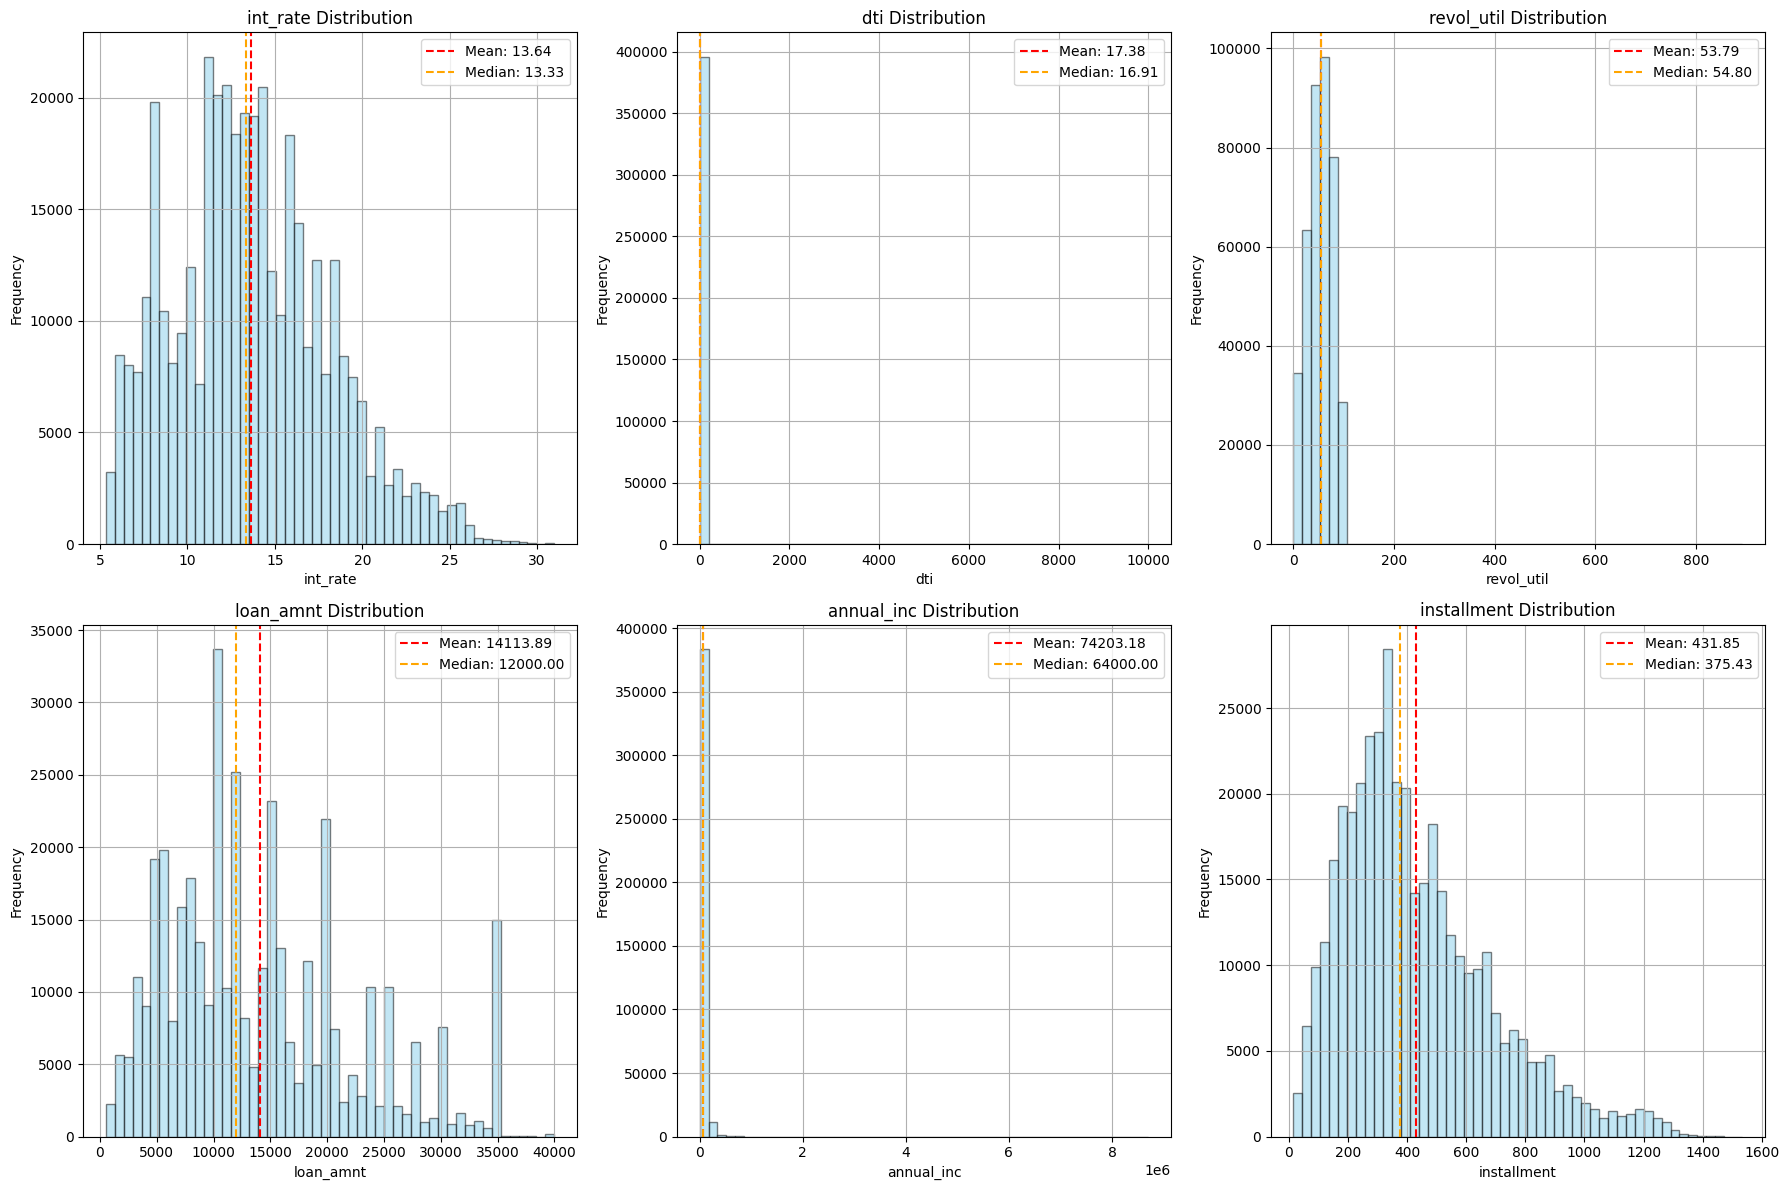

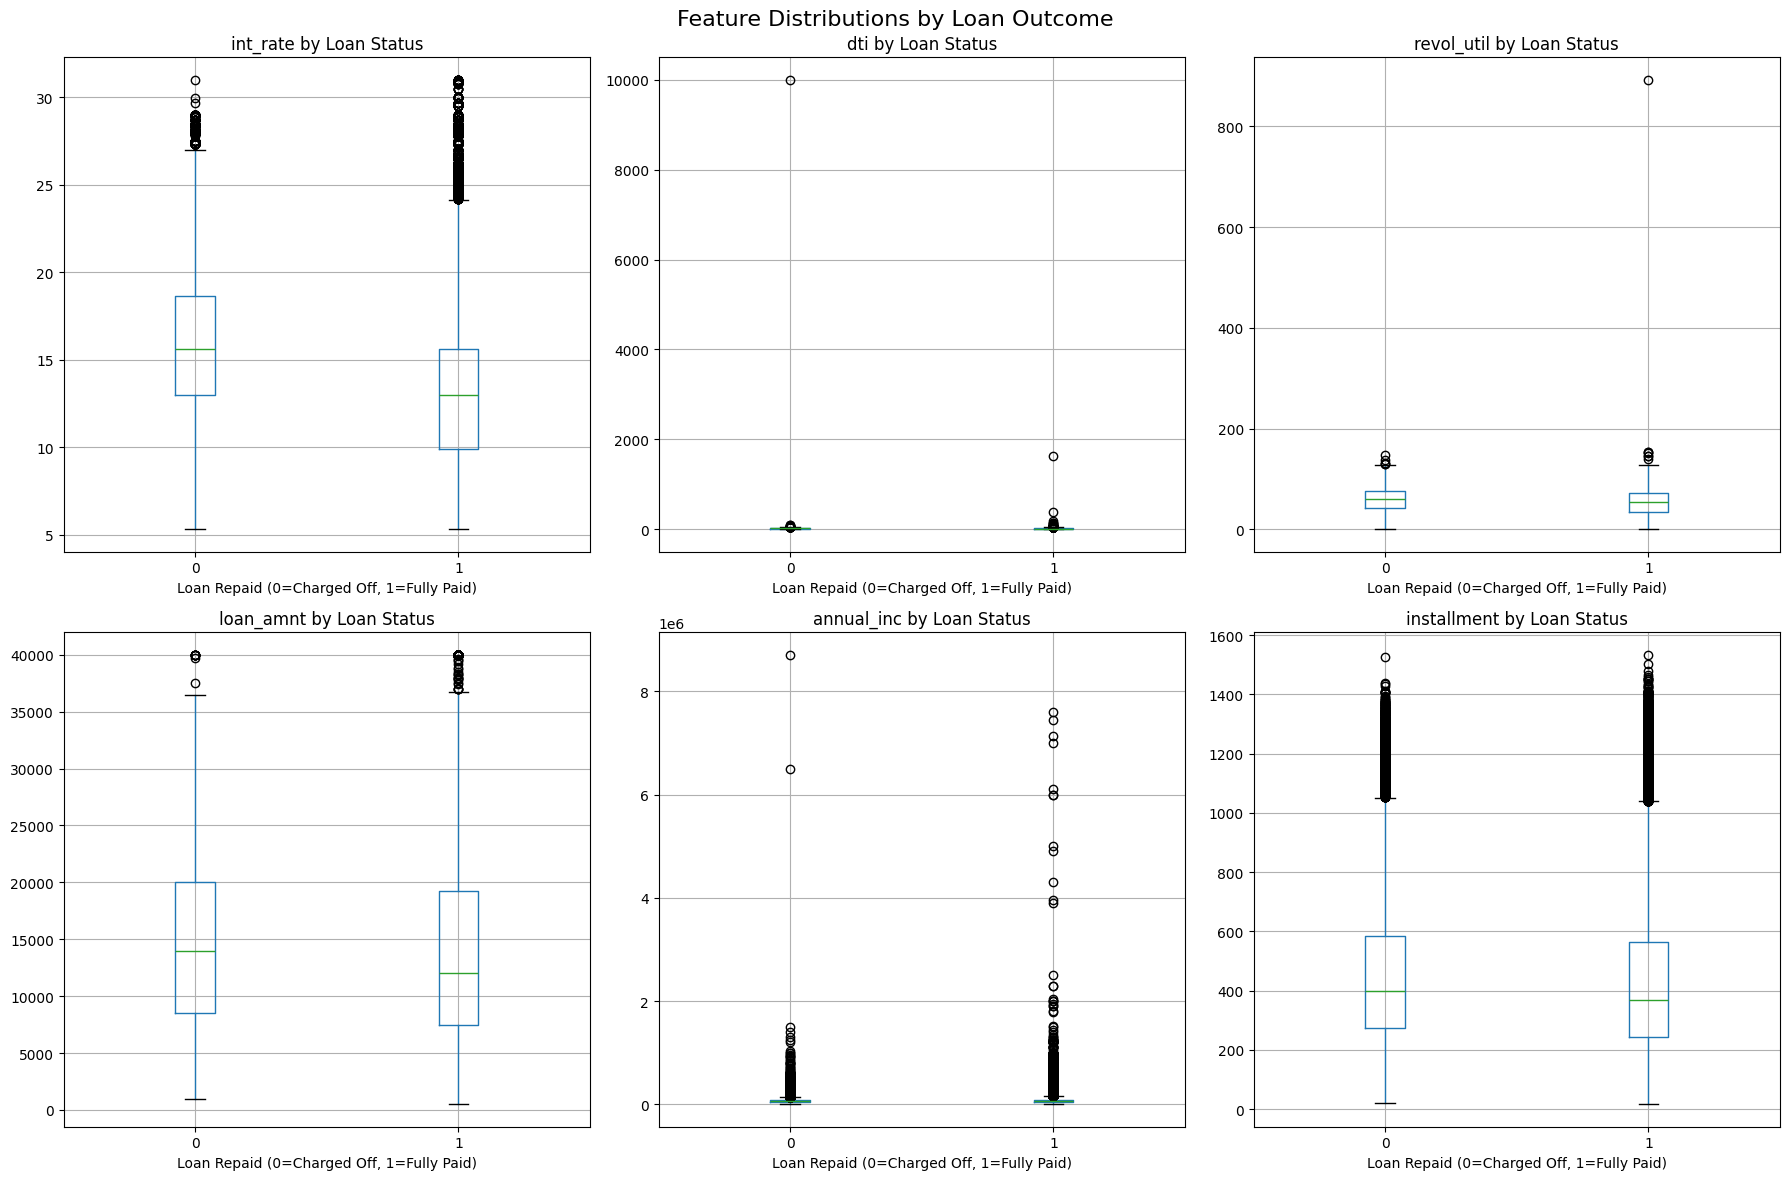

In [42]:
key_feats = ['int_rate', 'dti', 'revol_util', 'loan_amnt', 'annual_inc', 'installment']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, f in enumerate(key_feats):
    # dist plot
    df[f].hist(bins=50, ax=axes[i], alpha=0.5, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{f} Distribution')
    axes[i].set_xlabel(f)
    axes[i].set_ylabel('Frequency')
    
    # add stats
    mean_val = df[f].mean()
    median_val = df[f].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='orange', linestyle='--', label=f'Median: {median_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# box plots by target variable for key feats
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, f in enumerate(key_feats):
    df.boxplot(column=f, by='loan_repaid', ax=axes[i])
    axes[i].set_title(f'{f} by Loan Status')
    axes[i].set_xlabel('Loan Repaid (0=Charged Off, 1=Fully Paid)')

plt.suptitle('Feature Distributions by Loan Outcome', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Categorical Feat Analysis


In [43]:
cate_feats = df.select_dtypes(include=["object"]).columns.drop("loan_status").tolist()

print(f"Categorical Features ({len(cate_feats)}):")
print(f"{'Column':<25}Unique values")
for f in cate_feats:
    print(f"- {f:<25} {df[f].nunique()}")

Categorical Features (14):
Column                   Unique values
- term                      2
- grade                     7
- sub_grade                 35
- emp_title                 173105
- emp_length                11
- home_ownership            6
- verification_status       3
- issue_d                   115
- purpose                   14
- title                     48816
- earliest_cr_line          684
- initial_list_status       2
- application_type          3
- address                   393700


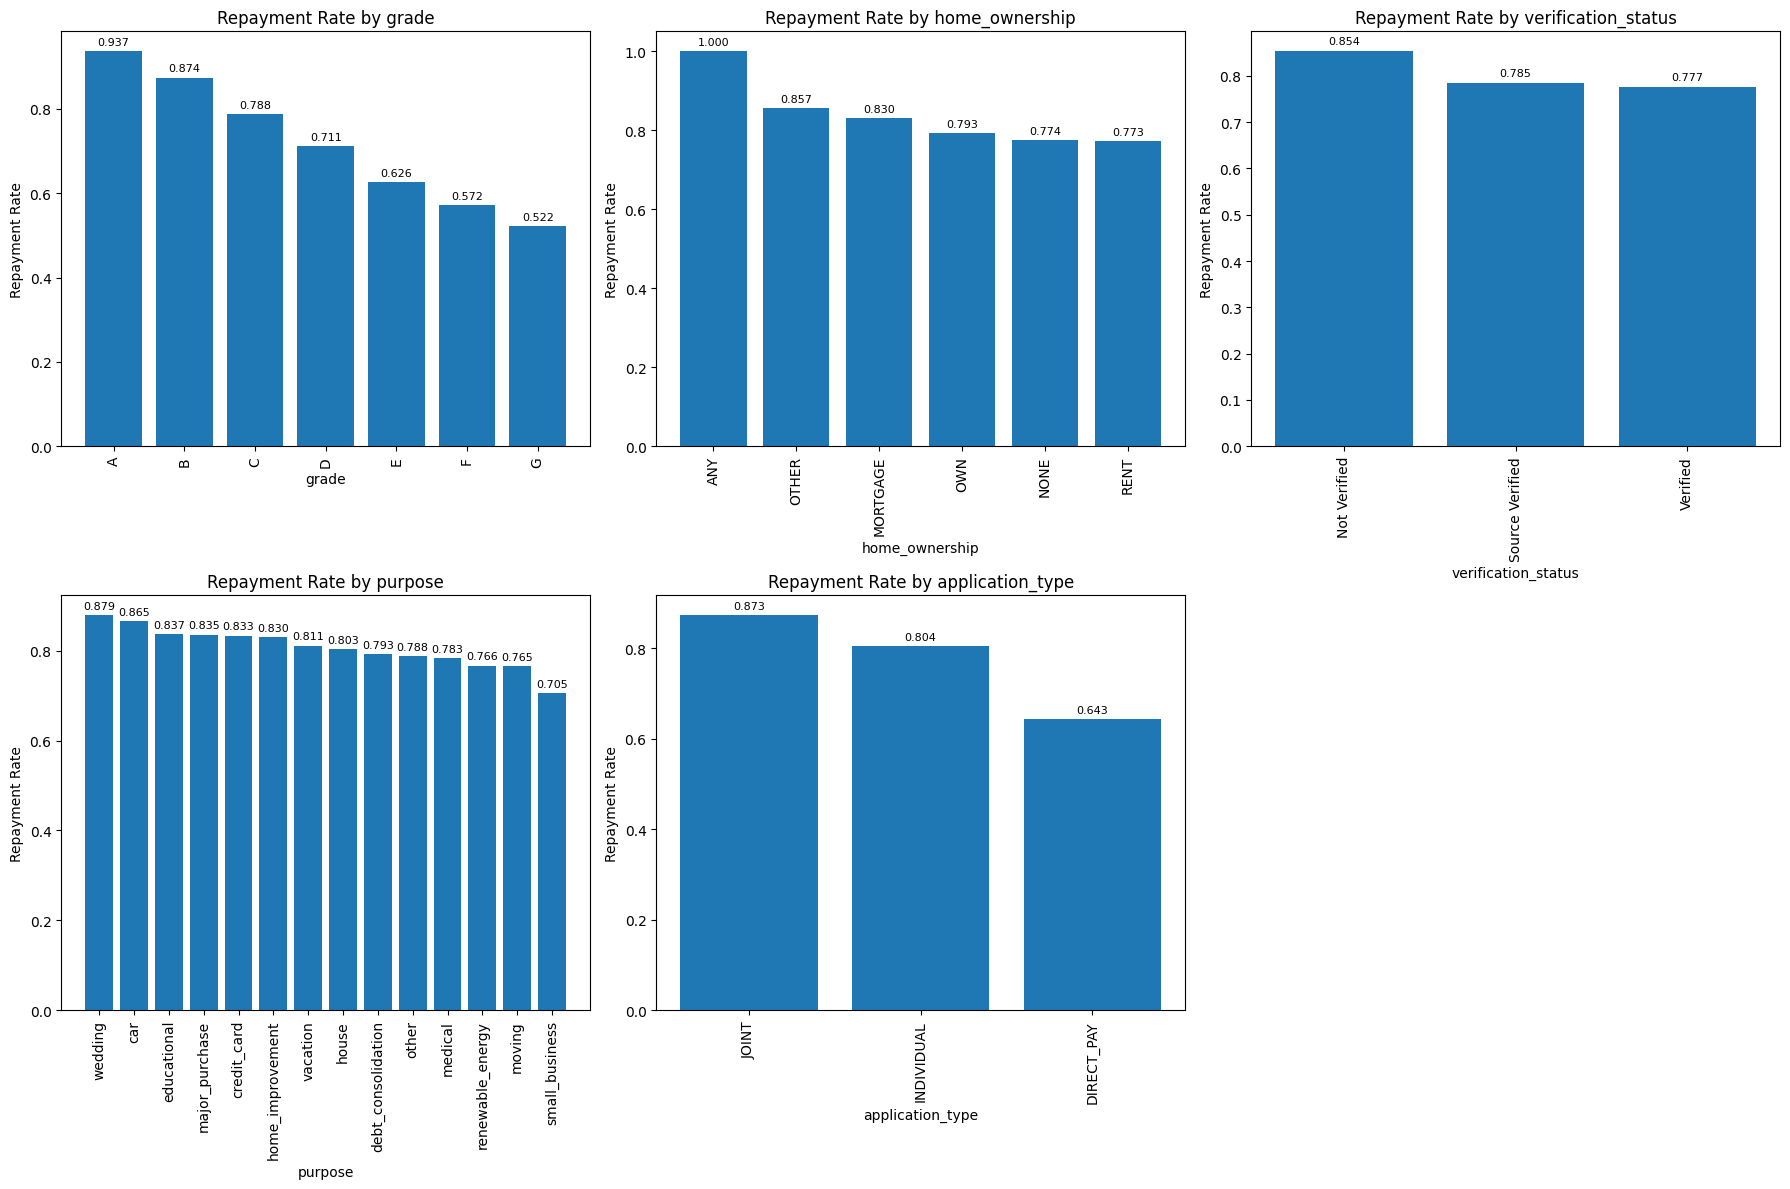


Repayment Rate Analysis by Feature:

GRADE:
       Repayment_Rate  Total_Loans  Fully_Paid  Charged_Off
grade                                                      
A               0.937        64187       60151         4036
B               0.874       116018      101431        14587
C               0.788       105987       83538        22449
D               0.711        63524       45186        18338
E               0.626        31488       19723        11765
F               0.572        11772        6735         5037
G               0.522         3054        1593         1461

HOME_OWNERSHIP:
                Repayment_Rate  Total_Loans  Fully_Paid  Charged_Off
home_ownership                                                      
ANY                      1.000            3           3            0
OTHER                    0.857          112          96           16
MORTGAGE                 0.830       198348      164716        33632
OWN                      0.793        37746       299

In [44]:
key_feats = ["grade", "home_ownership", "verification_status", "purpose", "application_type"]

# repayment rates by cate feats
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
fig.delaxes(axes[-1])

for i, f in enumerate(key_feats):
    # repayment rate by category
    repayment_rate = df.groupby(f)["loan_repaid"].agg(["mean", "count"]).reset_index()
    repayment_rate = repayment_rate.sort_values("mean", ascending=False)

    bars = axes[i].bar(range(len(repayment_rate)), repayment_rate["mean"])
    axes[i].set_title(f"Repayment Rate by {f}")
    axes[i].set_xlabel(f)
    axes[i].set_ylabel("Repayment Rate")
    axes[i].set_xticks(range(len(repayment_rate)))
    axes[i].set_xticklabels(repayment_rate[f], rotation=90)

    for j, bar in enumerate(bars):
        h = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2.0,
            h + 0.01,
            f"{h:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.tight_layout()
plt.show()

print("\nRepayment Rate Analysis by Feature:")
print("=" * 70)
for f in key_feats:
    print(f"\n{f.upper()}:")
    rates = df.groupby(f)["loan_repaid"].agg(["mean", "count", "sum"]).round(3)
    rates.columns = ["Repayment_Rate", "Total_Loans", "Fully_Paid"]
    rates["Charged_Off"] = rates["Total_Loans"] - rates["Fully_Paid"]
    print(rates.sort_values("Repayment_Rate", ascending=False))

## 6. Preprocessing


In [45]:
df_processed = df.copy()

# drop feats with high cardinality or too many missing values
to_drop = ["emp_title", "title", "address"]
df_processed = df_processed.drop(columns=to_drop)
print(f"Dropped features: {to_drop}")

# handle remaining missing values
# mort_acc: fill with median
med = df_processed["mort_acc"].median()
df_processed["mort_acc"].fillna(med, inplace=True)
print(f"Filled mort_acc with median: {med}")

# emp_length: convert to numeric and handle missing
emp_length_map = {
    "10+ years": 10,
    "9 years": 9,
    "8 years": 8,
    "7 years": 7,
    "6 years": 6,
    "5 years": 5,
    "4 years": 4,
    "3 years": 3,
    "2 years": 2,
    "1 year": 1,
    "< 1 year": 0,
}
df_processed["emp_length_num"] = df_processed["emp_length"].map(emp_length_map)
df_processed["emp_length_num"].fillna(-1, inplace=True)  # -1 for unknown
df_processed = df_processed.drop(columns=["emp_length"])

# pub_rec_bankruptcies: fill with 0
df_processed["pub_rec_bankruptcies"].fillna(0, inplace=True)

# revol_util: fill with median
median_revol_util = df_processed["revol_util"].median()
df_processed["revol_util"].fillna(median_revol_util, inplace=True)

print(f"Remaining missing values: {df_processed.isnull().sum().sum()}")

Dropped features: ['emp_title', 'title', 'address']
Filled mort_acc with median: 1.0
Remaining missing values: 0


## 7. Feature Engineering & Data Preparation


In [46]:
# convert date to "date"
df_processed["issue_d"] = pd.to_datetime(df_processed["issue_d"])
df_processed["earliest_cr_line"] = pd.to_datetime(df_processed["earliest_cr_line"])

# create new date-based feats
df_processed["credit_history_length"] = (
    df_processed["issue_d"] - df_processed["earliest_cr_line"]
).dt.days / 365.25
df_processed["issue_year"] = df_processed["issue_d"].dt.year
df_processed["issue_month"] = df_processed["issue_d"].dt.month

# create derived financial feats
df_processed["loan_to_income_ratio"] = df_processed["loan_amnt"] / (
    df_processed["annual_inc"] + 1
)
df_processed["installment_to_income_ratio"] = df_processed["installment"] / (
    df_processed["annual_inc"] / 12 + 1
)
df_processed["debt_to_credit_ratio"] = df_processed["revol_bal"] / (
    df_processed["revol_bal"] + df_processed["annual_inc"] + 1
)

# create grade numeric mapping
grade = {"A": 7, "B": 6, "C": 5, "D": 4, "E": 3, "F": 2, "G": 1}
df_processed["grade_numeric"] = df_processed["grade"].map(grade)

# total credit accounts
df_processed["total_credit_lines"] = (
    df_processed["open_acc"] + df_processed["total_acc"]
)

new_feats = [
    "credit_history_length",
    "issue_year",
    "issue_month",
    "loan_to_income_ratio",
    "installment_to_income_ratio",
    "debt_to_credit_ratio",
    "grade_numeric",
    "total_credit_lines",
]
print("New features created:\n", new_feats)
print(f"\nProcessed dataset shape: {df_processed.shape}")

New features created:
 ['credit_history_length', 'issue_year', 'issue_month', 'loan_to_income_ratio', 'installment_to_income_ratio', 'debt_to_credit_ratio', 'grade_numeric', 'total_credit_lines']

Processed dataset shape: (396030, 33)


### 7.1 Feature Selection & Encoding


In [47]:
# encode categorical vars
cate_cols = [
    "term",
    "grade",
    "sub_grade",
    "home_ownership",
    "verification_status",
    "purpose",
    "initial_list_status",
    "application_type",
]

label_encoders = {}
for c in cate_cols:
    le = LabelEncoder()
    df_processed[f"{c}_encoded"] = le.fit_transform(df_processed[c])
    label_encoders[c] = le

# drop original cate_cols & unnecessary feats
to_drop = ["loan_status", "issue_d", "earliest_cr_line"] + cate_cols
df_model = df_processed.drop(columns=[c for c in to_drop if c in df_processed.columns])

print("Features after encoding and cleaning:")
print(f"Total features: {len(df_model.columns) - 1}")  # -1 for target
print(f"Dataset shape: {df_model.shape}")

Features after encoding and cleaning:
Total features: 29
Dataset shape: (396030, 30)


### 7.2 Correlation Analysis for Feature Selection


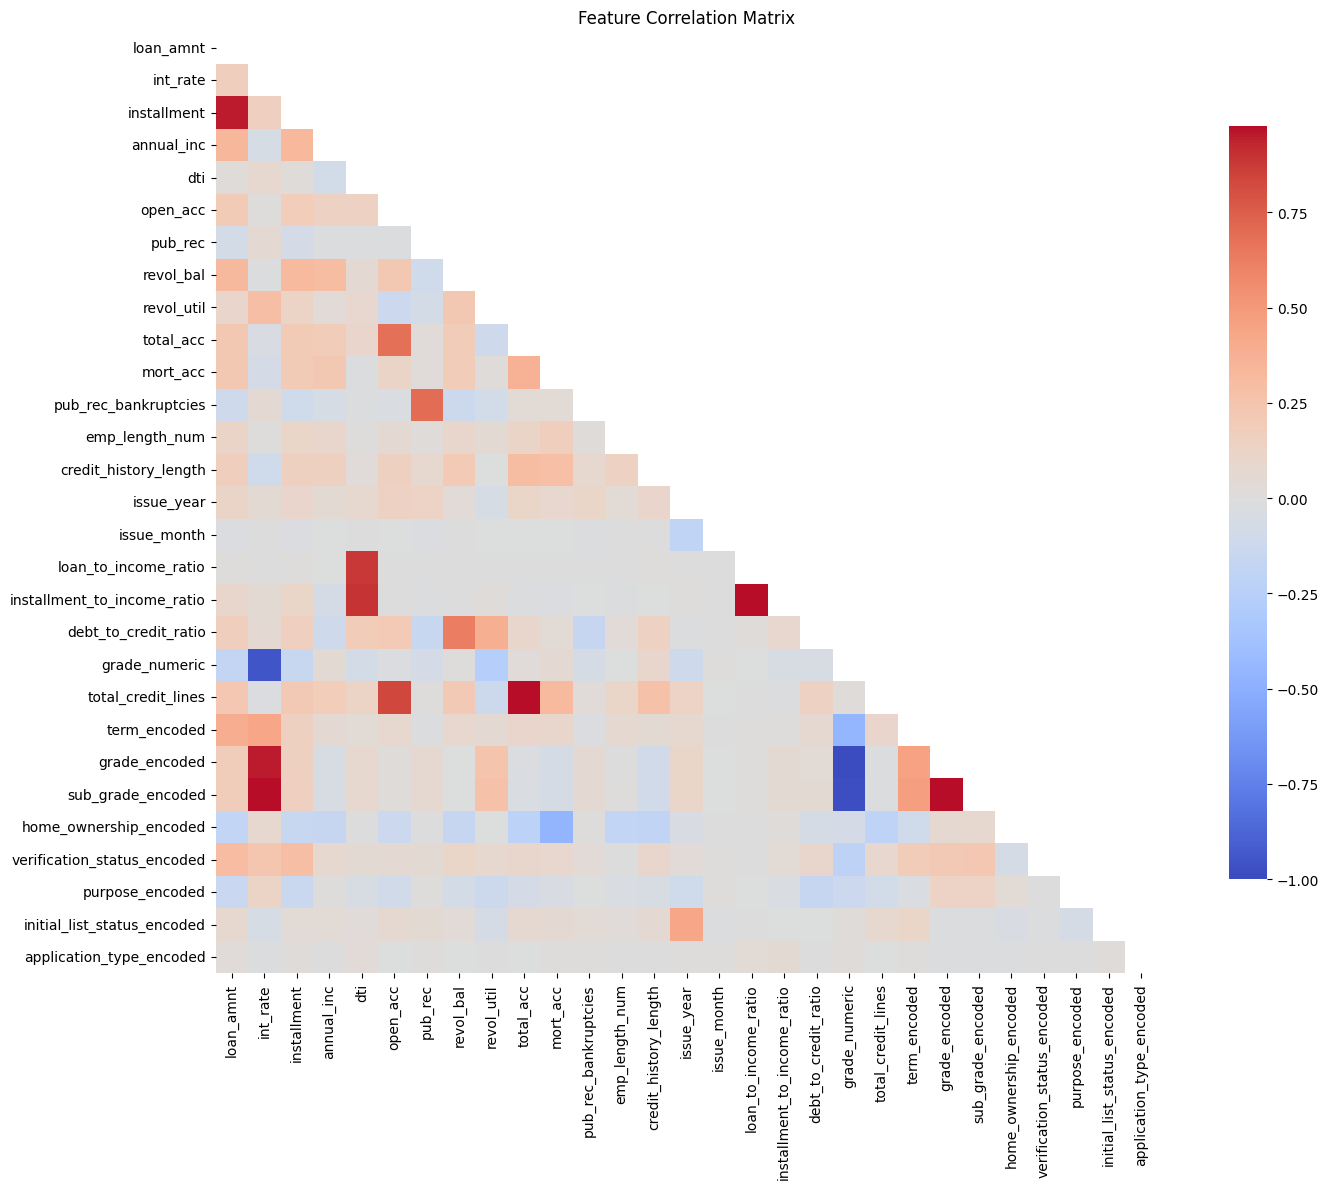


Highly correlated feature pairs (|r| > 0.8): 12
- grade_encoded & sub_grade_encoded: 0.978
- loan_to_income_ratio & installment_to_income_ratio: 0.977
- int_rate & sub_grade_encoded: 0.974
- total_acc & total_credit_lines: 0.971
- loan_amnt & installment: 0.954
- int_rate & grade_encoded: 0.952
- dti & installment_to_income_ratio: 0.895
- dti & loan_to_income_ratio: 0.884
- open_acc & total_credit_lines: 0.835
- int_rate & grade_numeric: -0.952
- grade_numeric & sub_grade_encoded: -0.978
- grade_numeric & grade_encoded: -1.000

Top 10 features correlated with target:
grade_numeric               0.257286
mort_acc                    0.065059
annual_inc                  0.053432
emp_length_num              0.028938
credit_history_length       0.026970
total_acc                   0.017893
issue_month                 0.016368
application_type_encoded    0.011296
revol_bal                   0.010892
total_credit_lines          0.004342
dtype: float64


In [48]:
num_feats_final = [c for c in df_model.columns if c != "loan_repaid"]
X, y = df_model[num_feats_final], df_model["loan_repaid"]

corr = X.corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(
    corr,
    mask=mask,
    annot=False,
    cmap="coolwarm",
    center=0,
    square=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8},
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# find highly correlated features (>0.8)
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.8:
            high_corr.append((
                    corr.columns[i],
                    corr.columns[j],
                    corr.iloc[i, j],
            ))

high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)
print(f"\nHighly correlated feature pairs (|r| > 0.8): {len(high_corr)}")
for pair in high_corr:
    print(f"- {pair[0]} & {pair[1]}: {pair[2]:.3f}")

# corr with target
corr_t = X.corrwith(y).sort_values(ascending=False)
print("\nTop 10 features correlated with target:")
print(corr_t.head(10))

### 7.3 Final Feature Selection & Data Prep


In [49]:
# remove highly correlated feats to reduce multicollinearity
to_drop = [
    "sub_grade_encoded",  # highly corr with grade_encoded and int_rate
    "installment_to_income_ratio",  # highly corr with loan_to_income_ratio
    "total_acc",  # keep total_credit_lines instead
    "loan_amnt",  # keep installment as it represents monthly burden
]

# select final feats
final_feats = [c for c in num_feats_final if c not in to_drop]
X_final, y_final = df_model[final_feats], df_model["loan_repaid"]

print(f"Final feature set: {len(final_feats)} features")
print("Selected features:")
for i, f in enumerate(final_feats, 1):
    print(f"{i:2d}. {f}")

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# scale feats
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData split completed:")
print(f"Training samples: {X_train_scaled.shape[0]:,}")
print(f"Test samples: {X_test_scaled.shape[0]:,}")
print(f"Features: {X_train_scaled.shape[1]}")

print("\nClass distribution:")
print(f"Training - Fully Paid: {y_train.mean():.3f}")
print(f"Test - Fully Paid: {y_test.mean():.3f}")

Final feature set: 25 features
Selected features:
 1. int_rate
 2. installment
 3. annual_inc
 4. dti
 5. open_acc
 6. pub_rec
 7. revol_bal
 8. revol_util
 9. mort_acc
10. pub_rec_bankruptcies
11. emp_length_num
12. credit_history_length
13. issue_year
14. issue_month
15. loan_to_income_ratio
16. debt_to_credit_ratio
17. grade_numeric
18. total_credit_lines
19. term_encoded
20. grade_encoded
21. home_ownership_encoded
22. verification_status_encoded
23. purpose_encoded
24. initial_list_status_encoded
25. application_type_encoded

Data split completed:
Training samples: 316,824
Test samples: 79,206
Features: 25

Class distribution:
Training - Fully Paid: 0.804
Test - Fully Paid: 0.804


### 7.4 Save Processed Data


In [50]:
os.makedirs("../data/processed", exist_ok=True)

# save scaled datasets
train_scaled = pd.DataFrame(X_train_scaled, columns=final_feats)
train_scaled["loan_repaid"] = y_train.reset_index(drop=True)

test_scaled = pd.DataFrame(X_test_scaled, columns=final_feats)
test_scaled["loan_repaid"] = y_test.reset_index(drop=True)

train_scaled.to_csv("../data/processed/train_data_scaled.csv", index=False)
test_scaled.to_csv("../data/processed/test_data_scaled.csv", index=False)

# save original scale datasets (for reference)
train_original = X_train.copy()
train_original["loan_repaid"] = y_train.reset_index(drop=True)

test_original = X_test.copy()
test_original["loan_repaid"] = y_test.reset_index(drop=True)

train_original.to_csv("../data/processed/train_data_original.csv", index=False)
test_original.to_csv("../data/processed/test_data_original.csv", index=False)

# save feat info & scaler params
feature_info = pd.DataFrame({"feature_name": final_feats, "data_type": "numerical"})
feature_info.to_csv("../data/processed/feature_info.csv", index=False)

scaler_params = pd.DataFrame(
    {"feature": final_feats, "mean": scaler.mean_, "scale": scaler.scale_}
)
scaler_params.to_csv("../data/processed/scaler_params.csv", index=False)

# save preprocessing metadata
metadata = {
    "dataset": {
        "original_samples": df.shape[0],
        "final_samples": df_model.shape[0],
        "original_features": df.shape[1],
        "final_features": len(final_feats),
        "target_balance": {
            "fully_paid_pct": float(y_final.mean()),
            "charged_off_pct": float(1 - y_final.mean())
        }
    },
    "data_quality": {
        "missing_handled": ["mort_acc", "emp_length", "pub_rec_bankruptcies", "revol_util"],
        "features_dropped": to_drop + ["emp_title", "title", "address"],
        "multicollinear_removed": ["sub_grade_encoded", "installment_to_income_ratio", "total_acc", "loan_amnt"]
    },
    "features": {
        "engineered_count": len(new_feats),
        "top_predictors": corr_t.head(5).index.tolist(),
        "categorical_encoded": len(cate_cols),
        "scaling_method": "StandardScaler"
    },
    "model_ready": {
        "train_samples": X_train_scaled.shape[0],
        "test_samples": X_test_scaled.shape[0],
        "feature_count": X_train_scaled.shape[1],
        "files_created": [
            "train_data_scaled.csv",
            "test_data_scaled.csv", 
            "feature_info.csv",
            "scaler_params.csv"
        ]
    }
}

with open("../data/processed/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

## 8. Insights and Summary

### Data Quality

- **Dataset**: 396,030 loan records reduced from 27 to 25 features
- **Missing Data**: Handled 4 features (mort_acc, emp_length, pub_rec_bankruptcies, revol_util)
- **Class Balance**: 80.4% fully paid vs 19.6% charged off

### Feature Engineering

- **Created 8 new features** from dates and financial ratios
- **Removed multicollinear features** to improve model stability
- **Top predictors**: grade_numeric, mort_acc, annual_inc, emp_length_num, credit_history_length

### Model-Ready Data

- **Training**: 316,824 samples | **Test**: 79,206 samples
- **Features**: 25 scaled numerical features
- **Files**: train/test scaled CSVs + feature metadata saved

### Next Steps

1. Address class imbalance with weights or SMOTE
2. Focus on top 5 predictive features for initial modeling
3. Monitor for overfitting with validation curves
